# Outbrain Ad Click Through - Initial EDA
This project is using the US subset of Outbrain's global data provided for a kaggle comptition. (https://www.kaggle.com/c/outbrain-click-prediction)

This was the initial EDA runthrough, further refinements are made to the data (via randome sampling) to offset the missing data. The goal is to first do an analysis using as many categories as possible and then expand to information with missing data to see the impact.


In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import pickle
import random
import matplotlib
import matplotlib.cm as cm
import seaborn as sns
import datetime

matplotlib.style.use('ggplot') 
%matplotlib inline

# Train Data Set
This table shows which ads were displayed on a given site (document id) and which ad was clicked. A click for an ad is considered an event, and is covered in the next table.

In [2]:
# training set created from source daga in prior notebook
train = pd.read_csv('./data/train.csv')

In [3]:
train.head(10)

,display_id,ad_id,clicked,US
0,1,42337,0,1
1,1,139684,0,1
2,1,144739,1,1
3,1,156824,0,1
4,1,279295,0,1
5,1,296965,0,1
6,2,125211,0,1
7,2,156535,0,1
8,2,169564,0,1
9,2,308455,1,1


In [4]:
print(train.dtypes)
train.describe()

display_id    int64
ad_id         int64
clicked       int64
US            int64
dtype: object


,display_id,ad_id,clicked,US
count,6.728221e+07,6.728221e+07,6.728221e+07,67282211.0
mean,8.437118e+06,1.896809e+05,1.944860e-01,1.0
std,4.858572e+06,1.247405e+05,3.958045e-01,0.0
min,1.000000e+00,1.000000e+00,0.000000e+00,1.0
25%,4.195517e+06,9.637800e+04,0.000000e+00,1.0
50%,8.481444e+06,1.675010e+05,0.000000e+00,1.0
75%,1.261506e+07,2.523050e+05,0.000000e+00,1.0
max,1.687459e+07,5.480190e+05,1.000000e+00,1.0


In [5]:
print("Number of unique display_ID's (number of events): {0:,}".format(train['display_id'].nunique()))
print('Number of clicks (# of events): {0:,}'.format(np.sum(train['clicked'])))
print('Number of records: {0:,}'.format(len(train)))

Number of unique display_ID's (number of events): 13,085,451
Number of clicks (# of events): 13,085,451
Number of records: 67,282,211


In [6]:
peek = pd.pivot_table(train, index='ad_id', values=['display_id'], aggfunc='count').sort_values(by='display_id',\
                    ascending = False)
peek.columns = ['ad_id_count']
peek.describe()

,ad_id_count
count,449840.000000
mean,149.569205
std,1535.896224
min,1.000000
25%,2.000000
50%,5.000000
75%,16.000000
max,165522.000000


75% of the ads to US users were displayed 16 times or less, with the max # of displays for a single ad being over 165k.

In [7]:
ad_count = train.groupby('display_id')['ad_id'].count().value_counts()/train['display_id'].nunique()

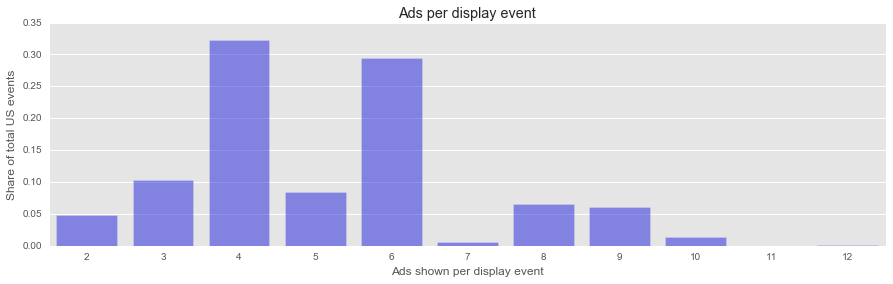

In [8]:
plt.figure(figsize=(15,4))
sns.barplot(ad_count.index, ad_count.values, color='blue', alpha=0.5)
plt.title('Ads per display event')
plt.xlabel('Ads shown per display event', fontsize=12)
plt.ylabel('Share of total US events', fontsize=12);

The ad count per event is weighted heavily towards 4 and 6 ad displays per page (just over 60%), with almost another quarter from 2, 3, and 5 per event.

In [9]:
ad_occ = train.groupby('ad_id')['ad_id'].count()

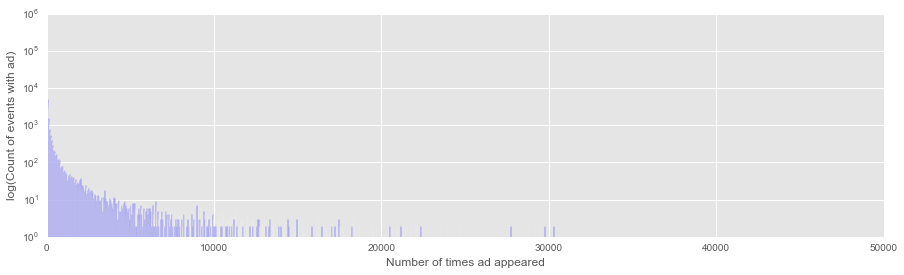

In [10]:
plt.figure(figsize=(15,4))
plt.hist(ad_occ.values, alpha = 0.5, color = 'blue', bins = 5000,range=(0,50000))
plt.xlabel('Number of times ad appeared', fontsize=12)
plt.ylabel('log(Count of events with ad)', fontsize=12)
plt.yscale('log')
#plt.ylim([0,2])
plt.show();

In [11]:
print np.percentile(ad_occ, np.arange(0, 100, 10)) # gives the start of each decile


[  1.   1.   1.   2.   3.   5.   8.  12.  22.  70.]


The chart and decile count show that a large percentage of the adds appear very few times, **with over 50% appearing less than 5 times.** 

From this it appears that we will not be able to use the ad iteself as a predictor, but will need to build some other linkages. Possibly the docuemnt subject matter (based on confidence level), advertiser or campaign, etc.


In [12]:
peek.tail()

,ad_id_count
ad_id,
427559,1
427555,1
236470,1
427552,1
548019,1


In [13]:
ad_joint = train.join(peek,on='ad_id',how='left')

In [14]:
ad_joint.head()

,display_id,ad_id,clicked,US,ad_id_count
0,1,42337,0,1,9470
1,1,139684,0,1,947
2,1,144739,1,1,45501
3,1,156824,0,1,45823
4,1,279295,0,1,271


In [15]:
disp_id_counts = pd.DataFrame(ad_joint['display_id'].value_counts())

In [16]:
disp_id_counts.columns=['display_id_count']

In [17]:
disp_id_counts.index.name = 'display_id'

In [18]:
disp_id_counts.head()

,display_id_count
display_id,
5962201,12
1340164,12
13241838,12
8748941,12
16477327,12


In [19]:
ad_joint = ad_joint.join(disp_id_counts,on='display_id',how='left')

In [20]:
ad_joint.head(12)

,display_id,ad_id,clicked,US,ad_id_count,display_id_count
0,1,42337,0,1,9470,6
1,1,139684,0,1,947,6
2,1,144739,1,1,45501,6
3,1,156824,0,1,45823,6
4,1,279295,0,1,271,6
5,1,296965,0,1,27,6
6,2,125211,0,1,1036,4
7,2,156535,0,1,1,4
8,2,169564,0,1,465,4
9,2,308455,1,1,680,4


In [21]:
# show distribution of ad occurences by # per event
singletons = ad_joint.loc[(ad_joint['ad_id_count'] >= 1)\
                          & (ad_joint['ad_id_count'] <=5),'display_id_count']
thousands = ad_joint.loc[(ad_joint['ad_id_count'] >= 1000)\
                         & (ad_joint['ad_id_count'] <=5000),'display_id_count']
tenk = ad_joint.loc[(ad_joint['ad_id_count'] >= 10000)\
                    & (ad_joint['ad_id_count'] <=15000),'display_id_count']
hundredk = ad_joint.loc[(ad_joint['ad_id_count'] >= 100000) ,'display_id_count']

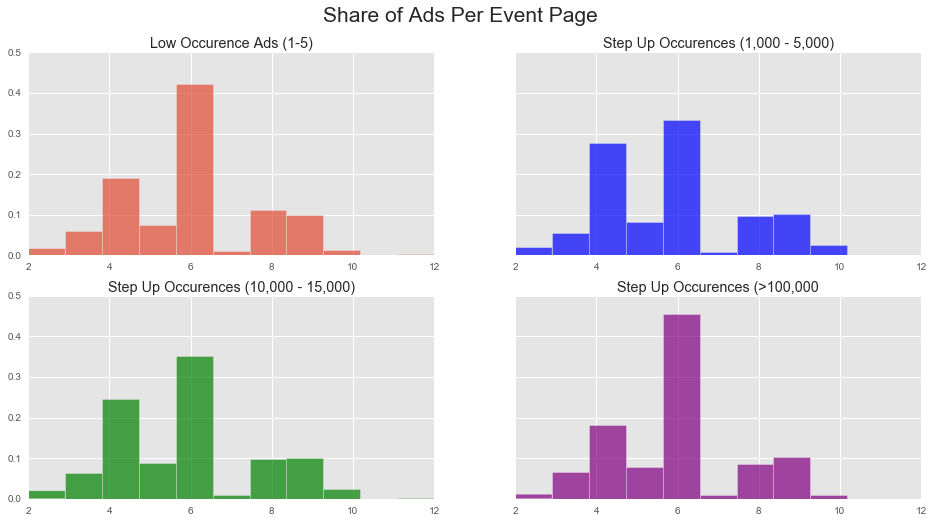

In [22]:
wght0 = np.ones_like(singletons)/float(len(singletons))
wght1 = np.ones_like(thousands)/float(len(thousands))
wght2 = np.ones_like(tenk)/float(len(tenk))
wght3 = np.ones_like(hundredk)/float(len(hundredk))

fig, ax = plt.subplots(2,2, figsize=(16,8), sharey = True)

category = 'Share of Ads Per Event Page'

ax[0,0].hist(singletons, bins=11, alpha = 0.7, weights = wght0)
ax[0,1].hist(thousands, bins=11,color = 'blue', alpha = 0.7, weights = wght1)
ax[1,0].hist(tenk, bins=11, color = 'green', alpha = 0.7, weights = wght2)
ax[1,1].hist(hundredk, bins=11, color = 'purple', alpha = 0.7, weights = wght3)


# individual graph titles
ax[0,0].set_title('Low Occurence Ads (1-5)')
ax[0,1].set_title('Step Up Occurences (1,000 - 5,000)')
ax[1,0].set_title('Step Up Occurences (10,000 - 15,000)')
ax[1,1].set_title('Step Up Occurences (>100,000')



# ax[1][0].set_ylim(0,5)
# ax[1][1].set_ylim(0,2)

fig.suptitle(category, fontsize=21);

In [23]:
clicked = ad_joint.loc[(ad_joint['clicked'] == 1),'ad_id_count']

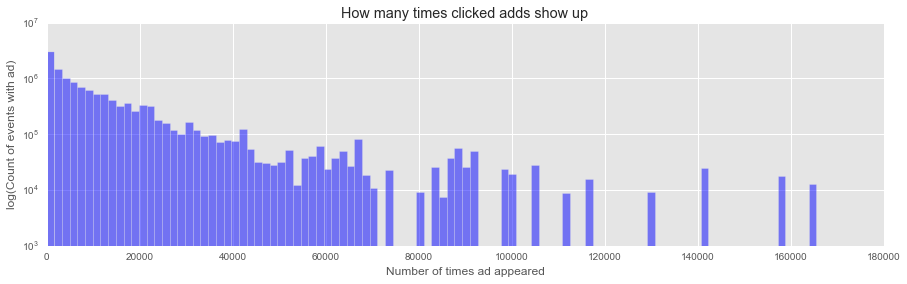

In [24]:
plt.figure(figsize=(15,4))
plt.hist(clicked, alpha = 0.5, color = 'blue',bins = 100)
plt.xlabel('Number of times ad appeared', fontsize=12)
plt.ylabel('log(Count of events with ad)', fontsize=12)
plt.yscale('log')
plt.title('How many times clicked adds show up');

In [25]:
# show distribution of clicked ads by # per event
single_click = ad_joint.loc[(ad_joint['ad_id_count'] >= 1) & (ad_joint['ad_id_count'] <=5)\
                          & (ad_joint['clicked'] == 1) ,'display_id_count']
onek_click = ad_joint.loc[(ad_joint['ad_id_count'] >= 1000) & (ad_joint['ad_id_count'] <=5000)\
                          & (ad_joint['clicked'] == 1),'display_id_count']
tenk_click = ad_joint.loc[(ad_joint['ad_id_count'] >= 10000) & (ad_joint['ad_id_count'] <=15000)\
                          & (ad_joint['clicked'] == 1),'display_id_count']
hundredk_click = ad_joint.loc[(ad_joint['ad_id_count'] >= 100000)\
                          & (ad_joint['clicked'] == 1) ,'display_id_count']

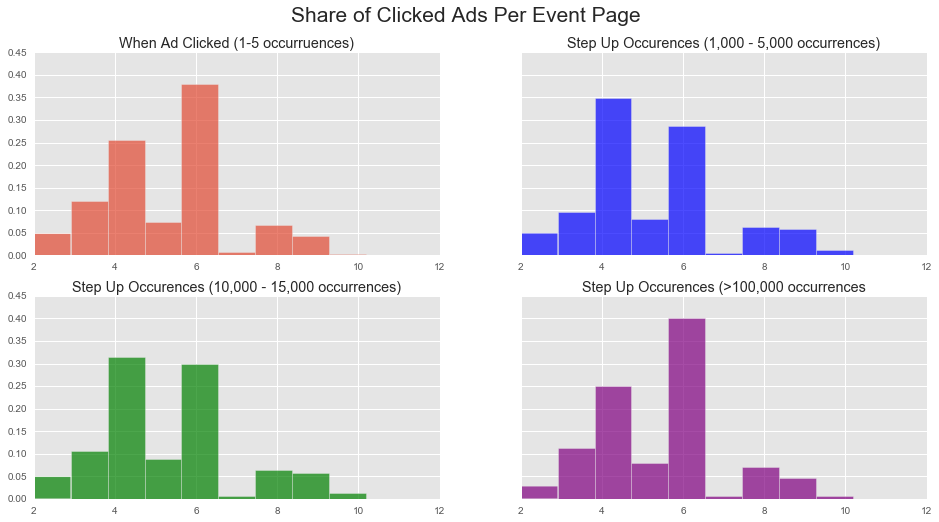

In [26]:
fig, ax = plt.subplots(2,2, figsize=(16,8), sharey = True)

wght0 = np.ones_like(single_click)/float(len(single_click))
wght1 = np.ones_like(onek_click)/float(len(onek_click))
wght2 = np.ones_like(tenk_click)/float(len(tenk_click))
wght3 = np.ones_like(hundredk_click)/float(len(hundredk_click))




category = 'Share of Clicked Ads Per Event Page'

ax[0,0].hist(single_click, bins=11, alpha = 0.7, weights = wght0)
ax[0,1].hist(onek_click, bins=11,color = 'blue', alpha = 0.7, weights = wght1)
ax[1,0].hist(tenk_click, bins=11, color = 'green', alpha = 0.7, weights = wght2)
ax[1,1].hist(hundredk_click, bins=11, color = 'purple', alpha = 0.7, weights = wght3)


# individual graph titles
ax[0,0].set_title('When Ad Clicked (1-5 occurruences)')
ax[0,1].set_title('Step Up Occurences (1,000 - 5,000 occurrences)')
ax[1,0].set_title('Step Up Occurences (10,000 - 15,000 occurrences)')
ax[1,1].set_title('Step Up Occurences (>100,000 occurrences')



# ax[1][0].set_ylim(0,5)
# ax[1][1].set_ylim(0,2)

fig.suptitle(category, fontsize=21);

# Event Data Set
For each click on an ad, this table ties together:
* the event # (display_id) 
* unique user (uuid),
* source document (also in train data set)
* time it was clicked (timestamp)
* the user platform (desktop = 1, mobile = 2, tablet =3)
* the users geo location.


In [27]:
events = pd.read_csv('./data/events.csv')

/Users/alex/anaconda/lib/python2.7/site-packages/IPython/core/interactiveshell.py:2723: DtypeWarning: Columns (4) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [28]:
events.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23120126 entries, 0 to 23120125
Data columns (total 6 columns):
display_id      int64
uuid            object
document_id     int64
timestamp       int64
platform        object
geo_location    object
dtypes: int64(3), object(3)
memory usage: 1.0+ GB


In [29]:
events.head()

,display_id,uuid,document_id,timestamp,platform,geo_location
0,1,cb8c55702adb93,379743,61,3,US>SC>519
1,2,79a85fa78311b9,1794259,81,2,US>CA>807
2,3,822932ce3d8757,1179111,182,2,US>MI>505
3,4,85281d0a49f7ac,1777797,234,2,US>WV>564
4,5,8d0daef4bf5b56,252458,338,2,SG>00


In [30]:
print(events['platform'].unique())
events['platform'].value_counts()


[3 2 1 '2' '1' '3' '\\N']


2     10684579
1      8747280
3      3032907
2       291699
1       279988
3        83668
\N           5
Name: platform, dtype: int64

* Clean the '\\N'- make np.NaN
* Convert string to integers
* decide what to do with NaN's

In [31]:
def platform_filter(x):
    if x == '\\N':
        return np.nan
    elif type(x) is str:
        return int(x)
    else:
        return x

# new column
events['platform'] = [platform_filter(x) for x in events['platform']]
events['platform'].unique()

array([  3.,   2.,   1.,  nan])

In [32]:
e_count = events['platform'].value_counts()

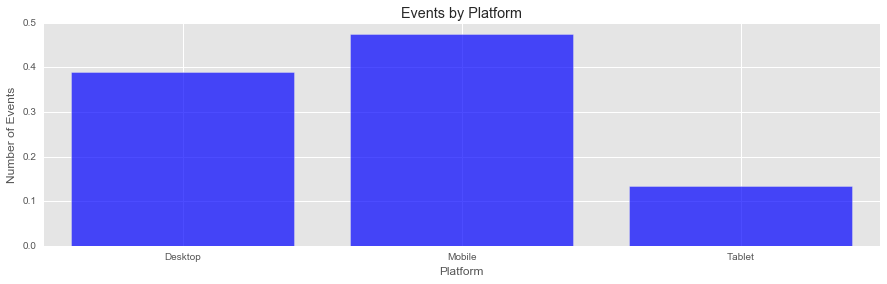

In [100]:
measure = e_count.values

fig, ax1 = plt.subplots(figsize=(15,4))
labels = ['Mobile', 'Desktop', 'Tablet']
ax1.bar(e_count.index, measure/float(sum(measure)), color='blue',
        alpha=0.7,tick_label=labels,align='center')
ax1.set_title('Events by Platform')
ax1.set_xlabel('Platform', fontsize=12)
ax1.set_ylabel('Number of Events', fontsize=12);

In [34]:
user_count = events.groupby('uuid')['uuid'].count().sort_values()


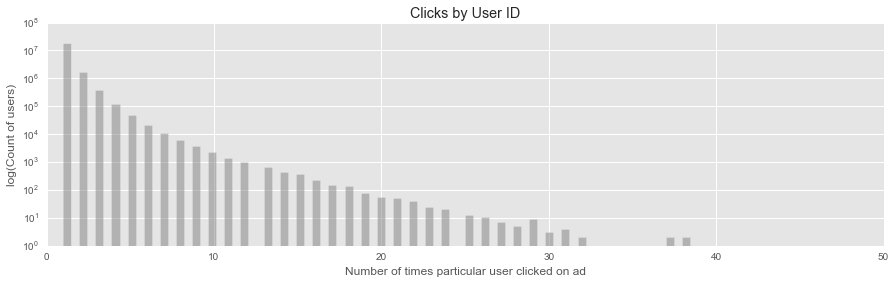

In [35]:
plt.figure(figsize=(15,4))
plt.hist(user_count.values, alpha = 0.5, color = 'grey',bins = 100)
plt.xlabel('Number of times particular user clicked on ad', fontsize=12)
plt.ylabel('log(Count of users)', fontsize=12)
plt.yscale('log')
plt.title('Clicks by User ID')
plt.show();


In [36]:
round((user_count < 2).mean() * 100, 2)

88.42

Most users click on very few ads, with **88% of ad clicks done by unique users**. Will not be able to develop any direct kind of user profiles for predicitons, may try by association (geo, time of day, type of platform).

In [37]:
events['country'] = events['geo_location'].str[0:2]

In [38]:
country_count = events.groupby('country')['country'].count().sort_values(ascending = False)
country_count.head(10)

country
US    18595452
CA     1215350
GB     1117544
AU      483021
IN      228461
ZA      111523
NZ      109802
PH       85338
DE       82384
SG       81975
Name: country, dtype: int64

In [39]:
country_count.sum()

23119786

In [40]:
print('The US constitutes {0:.2f}% of the data'.\
      format(100*country_count[0]/float(country_count.sum())))

The US constitutes 80.43% of the data


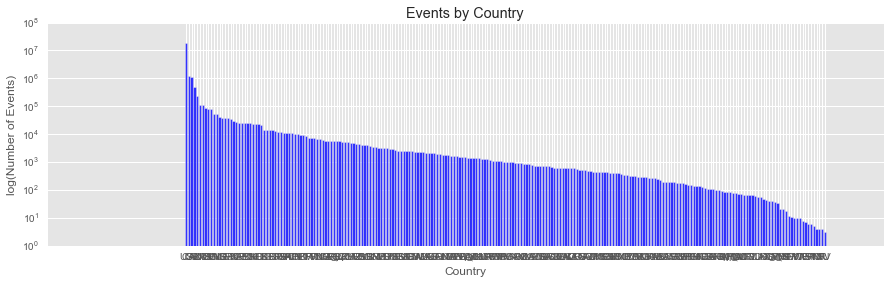

In [41]:
fig, ax1 = plt.subplots(figsize=(15,4))
X = np.arange(len(country_count.index))
ax1.bar(X, country_count.values, color='blue',\
        alpha=0.8,tick_label=country_count.index,align='center')
ax1.set_title('Events by Country')
ax1.set_xlabel('Country', fontsize=12)
ax1.set_yscale('log')
ax1.set_ylabel('log(Number of Events)', fontsize=12);

In [42]:
print('The US accounts for {0:.2f}% of the event clicks'.
      format(100*country_count[0]/float(len(events))))

The US accounts for 80.43% of the event clicks


In [43]:
# take only US data from events
# and break out other geographic data
events = events[events['country'] == 'US']
events['state'] = events['geo_location'].str[3:5]
events['DMA'] = events['geo_location'].str[6:]

In [44]:
events.head()

,display_id,uuid,document_id,timestamp,platform,geo_location,country,state,DMA
0,1,cb8c55702adb93,379743,61,3.0,US>SC>519,US,SC,519
1,2,79a85fa78311b9,1794259,81,2.0,US>CA>807,US,CA,807
2,3,822932ce3d8757,1179111,182,2.0,US>MI>505,US,MI,505
3,4,85281d0a49f7ac,1777797,234,2.0,US>WV>564,US,WV,564
5,6,7765b4faae4ad4,1773517,395,3.0,US>OH>510,US,OH,510


In [45]:
def filter_DMA(x):
    try:
        return str(int(x))
    except:
        return np.nan
    

In [46]:
events['DMA'] = [filter_DMA(x) for x in events['DMA']]


In [47]:
def filter_state(x):
    if x == '':
        return np.nan
    else:
        return x
    
events['state'] = [filter_state(x) for x in events['state']]


In [48]:
print('# rows mising state data: {0}'.format(len(events[events['state'].isnull()])))
print('# rows mising platform data: {0}'.format( len(events[events['platform'].isnull()])))
print('# rows mising DMA data: {0}'.format( len(events[events['DMA'].isnull()])))

# rows mising state data: 758487
# rows mising platform data: 5
# rows mising DMA data: 1264852


Almost 1.3m rows do not have a DMA code or platform data.

In [49]:
events['platform'].unique()

array([  3.,   2.,   1.,  nan])

In [50]:
# pd.pivot_table(events, index=['state','DMA'], values=['uuid'], aggfunc='count').\
#                sort_values(by='uuid', ascending = False)

In [51]:
from datetime import datetime
datetime.fromtimestamp(1465876800)
# the timestamp is adjusted to time zero for data colleciton, whcih is 6/14/2016

datetime.datetime(2016, 6, 14, 0, 0)

In [52]:
events['UTC_tstamp'] = [t + 1465876800 for t in events['timestamp']]
# events['UTC_date'] = [datetime.fromtimestamp(events['timestamp'] + 1465876800 )
# .strftime('%Y-%m-%d %H:%M:%S')]
# time zero is midnight June 4 UTC


In [53]:
events.head()

,display_id,uuid,document_id,timestamp,platform,geo_location,country,state,DMA,UTC_tstamp
0,1,cb8c55702adb93,379743,61,3.0,US>SC>519,US,SC,519,1465876861
1,2,79a85fa78311b9,1794259,81,2.0,US>CA>807,US,CA,807,1465876881
2,3,822932ce3d8757,1179111,182,2.0,US>MI>505,US,MI,505,1465876982
3,4,85281d0a49f7ac,1777797,234,2.0,US>WV>564,US,WV,564,1465877034
5,6,7765b4faae4ad4,1773517,395,3.0,US>OH>510,US,OH,510,1465877195


In [54]:
events['state'].unique()

array(['SC', 'CA', 'MI', 'WV', 'OH', 'MT', 'PA', 'FL', nan, 'IL', 'TX',
       'AZ', 'NC', 'OR', 'HI', 'NY', 'NJ', 'KY', 'WA', 'MD', 'MS', 'GA',
       'MO', 'MN', 'UT', 'LA', 'CO', 'IN', 'WI', 'KS', 'NM', 'TN', 'MA',
       'NV', 'AL', 'ME', 'IA', 'SD', 'OK', 'CT', 'ID', 'VA', 'AR', 'DE',
       'AK', 'NH', 'NE', 'ND', 'DC', 'RI', 'AE', 'VT', 'WY', 'AP', 'AA'], dtype=object)

AP and AA are for military mail code designations. AA Americas; AP Pacific 

In [123]:
disp_clean = events[(events['state'].notnull()) & (events['DMA'].notnull()) & (events['state'] != "AA") & \
                 (events['state'] != 'AP')]['display_id']

np.array(disp_clean.head)

array(<bound method Series.head of 0                  1
1                  2
2                  3
3                  4
5                  6
6                  7
7                  8
8                  9
10                11
11                12
12                13
13                14
15                16
16                17
17                18
18                19
19                20
20                21
21                22
26                27
27                28
28                29
29                30
30                31
34                35
35                36
36                37
37                38
38                39
39                40
              ...   
23120091    23120092
23120092    23120093
23120093    23120094
23120094    23120095
23120095    23120096
23120096    23120097
23120098    23120099
23120099    23120100
23120100    23120101
23120101    23120102
23120102    23120103
23120103    23120104
23120104    23120105
23120105    23120106
23120106    23120107

In [121]:
# this saves the list of US display_id's with good location data (new mix shown below)
# will be used to refilter events (pickle for notebook and csv for sql)

disp_clean.to_csv('./data/disp_filter.csv')

with open('disp_filter.pkl', 'w') as picklefile:
    pickle.dump(disp_clean, picklefile)

In [109]:

e_count2 = events[(events['state'].notnull()) & (events['DMA'].notnull()) & (events['state'] != "AA") & \
                 (events['state'] != 'AP')]['platform'].value_counts()

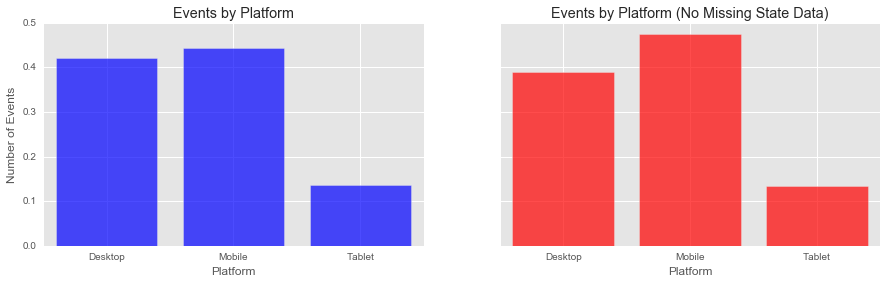

In [110]:
measure2 = e_count2.values

fig, ax = plt.subplots(1,2, figsize=(15,4),sharey = True)
labels = ['Mobile', 'Desktop', 'Tablet']
ax[0].bar(e_count2.index, measure2/float(sum(measure2)), color='blue',
        alpha=0.7,tick_label=labels,align='center')
ax[1].bar(e_count.index, measure/float(sum(measure)), color='red',
        alpha=0.7,tick_label=labels,align='center')
ax[0].set_title('Events by Platform')
ax[1].set_title('Events by Platform (No Missing State Data)')
ax[0].set_xlabel('Platform', fontsize=12)
ax[1].set_xlabel('Platform', fontsize=12)
ax[0].set_ylabel('Number of Events', fontsize=12);

### Clearning Data with Missing US Location Data
This slightly increases the mix of mobile vs desktop users, and after an initial model is established this can be revisted to see if imputing the data helps with model predictions.

Reasons for the gaps in data can not be directly deduced from the data avaialbe. It could be that more land based connections have gaps in geo location data, as mobile operators by their nature of passsing the device off from cell to cell, are likely to have better information on a users location.

## Promoted data
The document_id associated with each ad_id in the promoted content is the document to which the ad refers (i.e. you would use this table in order to find the topics, categories, or entities referred to in an ad). One or more ads may point to the same document.

In [58]:
promoted = pd.read_csv('./data/promoted_content.csv')
promoted.head()

,ad_id,document_id,campaign_id,advertiser_id
0,1,6614,1,7
1,2,471467,2,7
2,3,7692,3,7
3,4,471471,2,7
4,5,471472,2,7


In [59]:
promoted.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 559583 entries, 0 to 559582
Data columns (total 4 columns):
ad_id            559583 non-null int64
document_id      559583 non-null int64
campaign_id      559583 non-null int64
advertiser_id    559583 non-null int64
dtypes: int64(4)
memory usage: 17.1 MB


In [60]:
pd.pivot_table(promoted, index=['advertiser_id','campaign_id'], values=['ad_id'],\
               aggfunc = 'count').head()

ad_id
advertiser_id campaign_id       
2             21016            2
3             26266           12
4             3837             3
              3838            15
              4018            17

In [61]:
pd.pivot_table(promoted, index=['advertiser_id'], values=['ad_id'],aggfunc = 'count').\
                 sort_values(by='ad_id', ascending = False).head()

,ad_id
advertiser_id,
266,16529
1635,15450
3829,14844
1634,10552
3922,10046


No particular ad appeared more than 3,806 times, and no particular advertiser had more than 16,529 ads.

## Document Data

* meta data
    * source_id (the part of the site on which the document is displayed, e.g. edition.cnn.com)
    * publisher_id (e.g. cnn.com)
    * publish_time
* document description - provide information about the content in a document, as well as Outbrain's confidence in each respective relationship. Their can be more than one per docuemnt/ad.
    * topic data
    * entity data
    * category data

In [62]:
d_meta = pd.read_csv('./data/documents_meta.csv')
d_meta.head()

,document_id,source_id,publisher_id,publish_time
0,1595802,1.0,603.0,2016-06-05 00:00:00
1,1524246,1.0,603.0,2016-05-26 11:00:00
2,1617787,1.0,603.0,2016-05-27 00:00:00
3,1615583,1.0,603.0,2016-06-07 00:00:00
4,1615460,1.0,603.0,2016-06-20 00:00:00


In [63]:
d_meta.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2999334 entries, 0 to 2999333
Data columns (total 4 columns):
document_id     int64
source_id       float64
publisher_id    float64
publish_time    object
dtypes: float64(2), int64(1), object(1)
memory usage: 91.5+ MB


In [64]:
np.sort(d_meta.publish_time.unique())

array([nan, '0002-11-27 19:00:00', '0002-11-29 19:00:00', ...,
       '3011-03-30 00:00:00', '3012-05-03 00:00:00', '9953-03-01 00:00:00'], dtype=object)

In [65]:
d_meta.publish_time.isnull().sum()

1011118

<font color='red'>**About 25% of publish times are nan, and some are future time (ahead of time range sampled)**</font> 
Not sure how to use this data

In [66]:
d_meta.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2999334 entries, 0 to 2999333
Data columns (total 4 columns):
document_id     int64
source_id       float64
publisher_id    float64
publish_time    object
dtypes: float64(2), int64(1), object(1)
memory usage: 91.5+ MB


In [67]:
print('Unique Publishers (cnn.com): {0:,}'.format(len(d_meta.source_id.unique())))
print('Unique Sources (edition.cnn.com): {0:,}'.format(len(d_meta.publisher_id.unique())))

Unique Publishers (cnn.com): 14,395
Unique Sources (edition.cnn.com): 1,260


place holder

In [68]:
d_top = pd.read_csv('./data/documents_topics.csv')
d_ent = pd.read_csv('./data/documents_entities.csv')
d_cat = pd.read_csv('./data/documents_categories.csv')

In [115]:
print(d_top.topic_id.unique())
print(d_ent.entity_id.unique())
print(d_cat.category_id.unique())

# no missing descriptive ID's as seen below (no nan's or empty positions.)

[140  16 143 170 113 260  92 168  54 207 258  10 148  89 198  26  84 262
 108 202  72 242 221 192 279   2 274  32 100  65  86 249  66 193 285 298
  67 107 196 281  74  64  20  55 109  50  62 142  75 297 296 110  68 160
 181 153  85 176 155  52 171  69 131 136 165 219  24 228 141   8 128 149
 105  71 173  90 162  46 213  81  43 276  19  29 177 204  95 144 290 287
  25 121 254  42   1  94 265 271 102 223 130 295  35 175 231 179 268 145
 184 163 244  61 112  56 154 138 190  57 232 239 235 250 104   5 291 180
 174  23  17   9 226 132 247 167 266 201 277 156 252 292 123  13 200 208
 272 191  78 259 286  97 125  80 218  37  73  22 243 246 294 283 289  31
 217 248  27 183 150  60  48 257 159 241   0 288 264  93  15 199 256  44
 103  21 238 194 269 282 135 206 119 230 118 209 270  82 172 147 134 237
  36  79 225  76 275  38  14 106  58  30 129 229 124  41  49  39 233  11
 117 211 227  87 216   4   3   7 188  53 186 120 224 299  33  91 157 251
 137 220  77 158  47 139 111  63 178 146 280 253 23

In [69]:
print('Unique Topics: {0:,}'.format(len(d_top.topic_id.unique())))
d_top.head()

Unique Topics: 300


,document_id,topic_id,confidence_level
0,1595802,140,0.073113
1,1595802,16,0.059416
2,1595802,143,0.045421
3,1595802,170,0.038867
4,1524246,113,0.196450


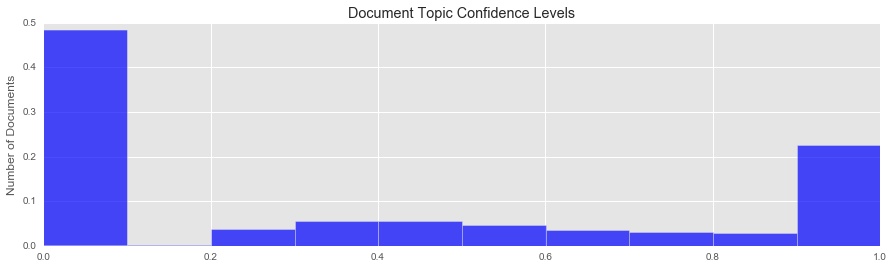

In [70]:
measure = d_cat.confidence_level

# to normalize a histogram
wght = np.ones_like(measure)/float(len(measure))

fig, ax1 = plt.subplots(figsize=(15,4))
ax1.hist(measure, weights = wght, alpha=0.7, color = 'blue')
ax1.set_title('Document Topic Confidence Levels')
ax1.set_ylabel('Number of Documents', fontsize=12);
# d_top.confidence_level[d_top.confidence_level > 0.2]


In [71]:
print('Unique Topics: {0:,}'.format(len(d_ent.entity_id.unique())))
d_ent.head()

Unique Topics: 1,326,009


,document_id,entity_id,confidence_level
0,1524246,f9eec25663db4cd83183f5c805186f16,0.672865
1,1524246,55ebcfbdaff1d6f60b3907151f38527a,0.399114
2,1524246,839907a972930b17b125eb0247898412,0.392096
3,1524246,04d8f9a1ad48f126d5806a9236872604,0.213996
4,1617787,612a1d17685a498aff4f036c1ee02c16,0.386193


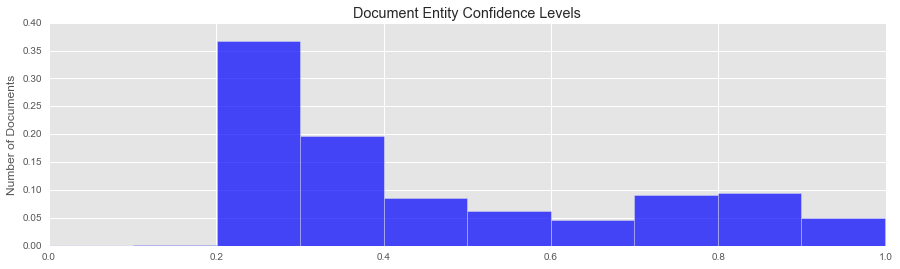

In [72]:
measure = d_ent.confidence_level

# to normalize a histogram
wght = np.ones_like(measure)/float(len(measure))

fig, ax1 = plt.subplots(figsize=(15,4))
ax1.hist(measure, weights = wght, alpha=0.7, color = 'blue')
ax1.set_title('Document Entity Confidence Levels')
ax1.set_ylabel('Number of Documents', fontsize=12);


In [73]:
print('Unique Categories: {0:,}'.format(len(d_cat.category_id.unique())))
d_cat.head()

Unique Categories: 97


,document_id,category_id,confidence_level
0,1595802,1611,0.92
1,1595802,1610,0.07
2,1524246,1807,0.92
3,1524246,1608,0.07
4,1617787,1807,0.92


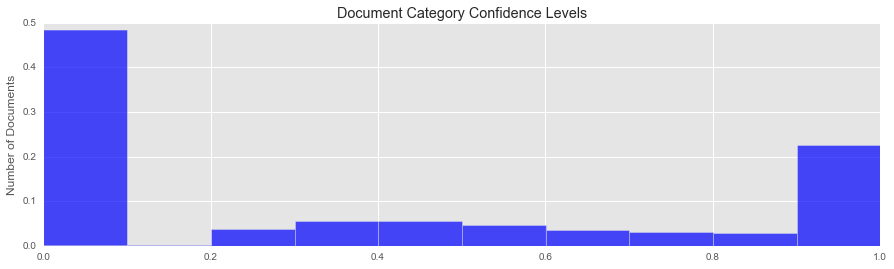

In [74]:
measure = d_cat.confidence_level

# to normalize a histogram
wght = np.ones_like(measure)/float(len(measure))

fig, ax1 = plt.subplots(figsize=(15,4))
ax1.hist(measure, weights = wght, alpha=0.7, color = 'blue')
ax1.set_title('Document Category Confidence Levels')
ax1.set_ylabel('Number of Documents', fontsize=12);



# <font color='red'>Pick up here:</font> 

- To do in SQL
   * Time Zone correction
   * Reduce original train data first to new train/test in pandas, the use sql to add on other data
   * merge data into train_us set 
       - Timestamp (corrected time zone)
       - userid
       - platform type
       - promoted and doc data as well (not sure how to do multiple topics yet)
       - Since documents can have multiple topics, how to do the matching?
       
       
- Promoted Data
   - advertiser_id can have multiple campaign_id's
   - but each campaing id is tied to a single advertiser_ID
   - so, do i need to use both as classifier's?
   
   
- Publish time on the ads seems odd 
   * 25% nan, some after end of data collection period
   * not sure if i shoudl use, can check actual adds and publish times
       
# <font color= 'blue'>For cleaning train/test:</font> 

1. Take states "AA" and "AP" out of states (tied to military, coudl be any timezone)